# Matching

In [1]:
import RF_Track as RFT
import numpy as np
import matplotlib.pyplot as plt

## Bunch parameters

In [2]:
# Bunch parameters
mass = RFT.electronmass # MeV/c^2
charge = -1 # single-particle charge, in units of e
population = 1*RFT.nC # number of real particles per bunch
Pc = 5 # reference momentum, MeV/c
P_Q = Pc / charge # MV/c, reference rigidity

## FODO cell parameters

In [3]:
# FODO cell parameters
Lcell = 2 # m
Lquad = 0.2 # m
Ldrift = Lcell/2 - Lquad # m

mu = np.deg2rad(90) # deg
k1L = np.sin(mu/2) / (Lcell/4) # 1/m

strength = k1L * P_Q # MeV/m

## Let's define the elements

In [4]:
# Half a focusing quadrupole

Qf = RFT.Quadrupole(Lquad/2, strength/2)
Qf.set_tt_nsteps(10)

# A full, defocusing, quadrupole
QD = RFT.Quadrupole(Lquad, -strength)
QD.set_tt_nsteps(20)

# The Drift
Dr = RFT.Drift(Ldrift)
Dr.set_tt_nsteps(100)

# Let's define a lattice with 10 FODO cells

In [5]:
# Define the FODO cell
FODO = RFT.Lattice()
FODO.append(Qf)
FODO.append(Dr)
FODO.append(QD)
FODO.append(Dr)
FODO.append(Qf)

# Create the full lattice by repeating the FODO cell 10 times
L = RFT.Lattice()
for _ in range(10):
    L.append(FODO)

In [6]:
L.get_length()

20.0

In [7]:
L.size()

10

# ...and a bunch

In [8]:
# Define Twiss parameters
Twiss = RFT.Bunch6d_twiss()
Twiss.emitt_x = 0.001 # mm.mrad, normalized emittances
Twiss.emitt_y = 0.001 # mm.mrad
Twiss.alpha_x = 0.0
Twiss.alpha_y = 0.0
Twiss.beta_x = Lcell * (1 + np.sin(mu/2)) / np.sin(mu) # m
Twiss.beta_y = Lcell * (1 - np.sin(mu/2)) / np.sin(mu) # m

# Create the bunch
B0 = RFT.Bunch6d(mass, population, charge, Pc, Twiss, 10000)

In [9]:
print(Twiss.beta_x)
print(Twiss.beta_y)

3.414213562373095
0.5857864376269049


# Then, we can perform tracking

In [10]:
B1 = L.track(B0)

We can inquire the lattice to find out, for example, the Twiss parameters and the emittance

In [11]:
T = L.get_transport_table('%S %beta_x %beta_y %emitt_x %emitt_y %sigma_x %sigma_y');

Text(0, 0.5, '$\\beta$ [m]')

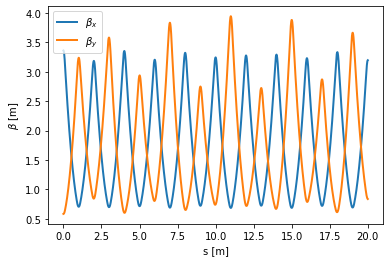

In [12]:
plt.plot(T[:,0], T[:,1], linewidth=2, label=r'$\beta_x$')
plt.plot(T[:,0], T[:,2], linewidth=2, label=r'$\beta_y$')
plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\beta$ [m]')

# Now we can match the Twiss paramters to be periodic
## Start with defining a merit function
This function returns zero when the initial and the final Twiss parameters are identical

In [13]:
from scipy.optimize import minimize_scalar

def match_K1(strength, FODO, B0):
    # Get quadrupoles from FODO
    Q = FODO.get_quadrupoles()
    Q[0].set_strength( strength / 2)
    Q[1].set_strength(-strength)
    Q[2].set_strength( strength / 2)

    # Perform tracking
    B1 = FODO.track(B0)
    I0 = B0.get_info()
    I1 = B1.get_info()

    # Compute the merit function
    M = ((I1.beta_x - I0.beta_x) ** 2 +
         (I1.beta_y - I0.beta_y) ** 2 +
         (I1.alpha_x + I0.alpha_x) ** 2 + # final alpha = -initial alpha
         (I1.alpha_y + I0.alpha_y) ** 2)

    print(strength, M)
    return M

Now, call the minization function ```minimize_scalar (func, bounds=(xmin, xmax), ... )```

In [14]:
# Define the merit function
merit = lambda S: match_K1(S, FODO, B0)

# Optimization settings and execution
result = minimize_scalar(merit, bounds=(-10, -5), method='bounded', options={'xatol': 1e-15})

strength = result.x  # Optimized strength

-8.090169943749475 0.04869378006066766
-6.909830056250526 0.15918692459507408
-8.819660112501051 0.7550613575689236
-7.584178944955649 0.005340207395734533
-7.676044489194547 0.0009656755545014311
-7.704081228175731 0.0005029909456771383
-7.72185871069282 0.0004336919950932637
-7.72005424367739 0.00043263143256944386
-7.719910078413179 0.000432626197413236
-7.719917998864248 0.00043262617994825175
-7.719917884359359 0.0004326261799481262
-7.719917769854471 0.000432626179955316


And build a new lattice with the matched FODO

In [15]:
L = RFT.Lattice()
for _ in range(10):
    L.append(FODO)

In [16]:
B1 = L.track(B0)

In [17]:
T = L.get_transport_table('%S %beta_x %beta_y %emitt_x %emitt_y %sigma_x %sigma_y')

Text(0, 0.5, '$\\beta$ [m]')

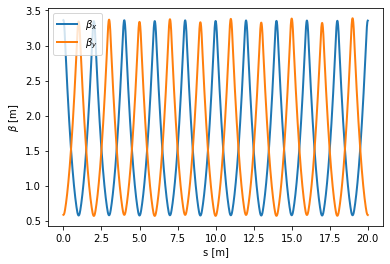

In [18]:
plt.plot(T[:,0], T[:,1], linewidth=2, label=r'$\beta_x$')
plt.plot(T[:,0], T[:,2], linewidth=2, label=r'$\beta_y$')
plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\beta$ [m]')